# Cohort analysis

In [ ]:
import pandas as pd

# Загрузка CSV файла
file_path = 'transactions.csv'  # Укажите путь к вашему файлу
df = pd.read_csv("/content/transactions.csv")

# Вывод первых 5 строк для проверки
print(df.head())

   user_id  mcc_code  currency_rk  transaction_amt     transaction_dttm
0        3         3            1      -183.883957  2022-01-28 12:05:33
1        3         3            1     -3206.437012  2022-01-28 12:52:30
2        3        16            1   -153866.890625  2022-02-16 14:45:56
3        3        56            1    -15144.601562  2022-03-09 19:58:29
4        3         0            1      5297.908691  2022-03-12 18:11:31


In [ ]:
df.dropna()

,user_id,mcc_code,currency_rk,transaction_amt,transaction_dttm
0,3,3,1,-183.883957,2022-01-28 12:05:33
1,3,3,1,-3206.437012,2022-01-28 12:52:30
2,3,16,1,-153866.890625,2022-02-16 14:45:56
3,3,56,1,-15144.601562,2022-03-09 19:58:29
4,3,0,1,5297.908691,2022-03-12 18:11:31
...,...,...,...,...,...
1405194,55930,1,1,-309.060669,2022-06-08 09:03:19
1405195,55930,0,1,3399.340576,2022-06-14 14:48:55
1405196,55930,13,1,-91.929306,2022-06-16 15:36:47
1405197,55930,3,1,-4628.930664,2022-06-17 18:43:51


In [ ]:
df.describe()

,user_id,mcc_code,currency_rk,transaction_amt
count,1.405199e+06,1.405199e+06,1.405199e+06,1.405199e+06
mean,2.827124e+04,1.557548e+01,9.587119e-01,-1.180897e+03
std,1.611294e+04,3.031636e+01,2.031888e-01,1.296121e+04
min,3.000000e+00,0.000000e+00,0.000000e+00,-2.195281e+05
25%,1.447500e+04,1.000000e+00,1.000000e+00,-1.048577e+03
50%,2.834700e+04,4.000000e+00,1.000000e+00,-3.714221e+02
75%,4.210500e+04,1.400000e+01,1.000000e+00,-1.343558e+02
max,5.593000e+04,4.130000e+02,3.000000e+00,3.332186e+05


In [ ]:
df['Date'] = pd.to_datetime(df['transaction_dttm'], format="%Y-%m-%d %H:%M:%S", errors='coerce')
df['order_month'] = df['Date'].dt.to_period('M') #создаем новый столбец - месяц и год покупки
df['cohort'] = df.groupby('user_id')['Date'].transform('min').dt.to_period('M')

In [ ]:
df.head()

,user_id,mcc_code,currency_rk,transaction_amt,transaction_dttm,Date,order_month,cohort
0,3,3,1,-183.883957,2022-01-28 12:05:33,2022-01-28 12:05:33,2022-01,2022-01
1,3,3,1,-3206.437012,2022-01-28 12:52:30,2022-01-28 12:52:30,2022-01,2022-01
2,3,16,1,-153866.890625,2022-02-16 14:45:56,2022-02-16 14:45:56,2022-02,2022-01
3,3,56,1,-15144.601562,2022-03-09 19:58:29,2022-03-09 19:58:29,2022-03,2022-01
4,3,0,1,5297.908691,2022-03-12 18:11:31,2022-03-12 18:11:31,2022-03,2022-01


для анализа, где нужно сгруппировать данные по первой покупке клиента и по месяцам последующих заказов.

In [ ]:
df_cohort = df.groupby(['cohort', 'order_month']) \
              .agg(n_customers=('user_id', 'nunique')) \
              .reset_index(drop=False)
df_cohort['period_number'] = (df_cohort['order_month'] - df_cohort['cohort']).apply(lambda x: x.n)

Сводная таблица (cohort_pivot) показывает, как изменяется количество клиентов для каждой когорты с течением времени (по месяцам). Каждая строка соответствует когорте (месяцу первой покупки клиентов), а каждый столбец — это период (количество месяцев с момента первой покупки). Значения в таблице — это количество уникальных клиентов, совершивших заказы в соответствующий период.

In [ ]:
cohort_pivot = df_cohort.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'n_customers')

In [ ]:
print(cohort_pivot)

period_number      0      1      2      3      4      5      6
cohort                                                        
2021-10        702.0  691.0  693.0  686.0  678.0  685.0  641.0
2021-11        728.0  716.0  713.0  715.0  711.0  696.0  605.0
2021-12        847.0  822.0  818.0  825.0  823.0  809.0  661.0
2022-01        739.0  725.0  714.0  719.0  721.0  712.0  616.0
2022-02        775.0  760.0  753.0  748.0  740.0  730.0  594.0
2022-03        745.0  726.0  720.0  726.0  717.0  695.0  561.0
2022-04        793.0  768.0  769.0  773.0  745.0  734.0  584.0
2022-05        886.0  867.0  857.0  852.0  834.0  817.0  608.0
2022-06        856.0  829.0  825.0  818.0  820.0  782.0  625.0
2022-07        821.0  804.0  804.0  794.0  778.0  762.0  592.0
2022-08        830.0  808.0  797.0  788.0  782.0  742.0  594.0
2022-09        878.0  854.0  840.0  841.0  824.0  793.0  634.0
2022-10        171.0  159.0  157.0  146.0  134.0  116.0    NaN
2022-11         40.0   38.0   30.0   27.0   23.0    NaN

вывод по нашей таблице

Количество клиентов уменьшается по мере увеличения номера периода, что обычно характерно для когорного анализа: часть клиентов перестает делать покупки с течением времени.
Некоторые когорты (например, 2022-10 и 2022-11) имеют очень небольшие значения в более поздних периодах, что может свидетельствовать о небольшом числе клиентов, продолжающих делать покупки через несколько месяцев.

In [ ]:
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)

В результате каждая ячейка в новой матрице (retention_matrix) будет содержать долю клиентов, совершивших покупку в соответствующий период по сравнению с числом клиентов, сделавших первую покупку

In [ ]:
print(retention_matrix)

period_number    0         1         2         3         4         5         6
cohort                                                                        
2021-10        1.0  0.984330  0.987179  0.977208  0.965812  0.975783  0.913105
2021-11        1.0  0.983516  0.979396  0.982143  0.976648  0.956044  0.831044
2021-12        1.0  0.970484  0.965762  0.974026  0.971665  0.955136  0.780401
2022-01        1.0  0.981055  0.966171  0.972936  0.975643  0.963464  0.833559
2022-02        1.0  0.980645  0.971613  0.965161  0.954839  0.941935  0.766452
2022-03        1.0  0.974497  0.966443  0.974497  0.962416  0.932886  0.753020
2022-04        1.0  0.968474  0.969735  0.974779  0.939470  0.925599  0.736444
2022-05        1.0  0.978555  0.967269  0.961625  0.941309  0.922122  0.686230
2022-06        1.0  0.968458  0.963785  0.955607  0.957944  0.913551  0.730140
2022-07        1.0  0.979294  0.979294  0.967113  0.947625  0.928136  0.721072
2022-08        1.0  0.973494  0.960241  0.949398  0.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

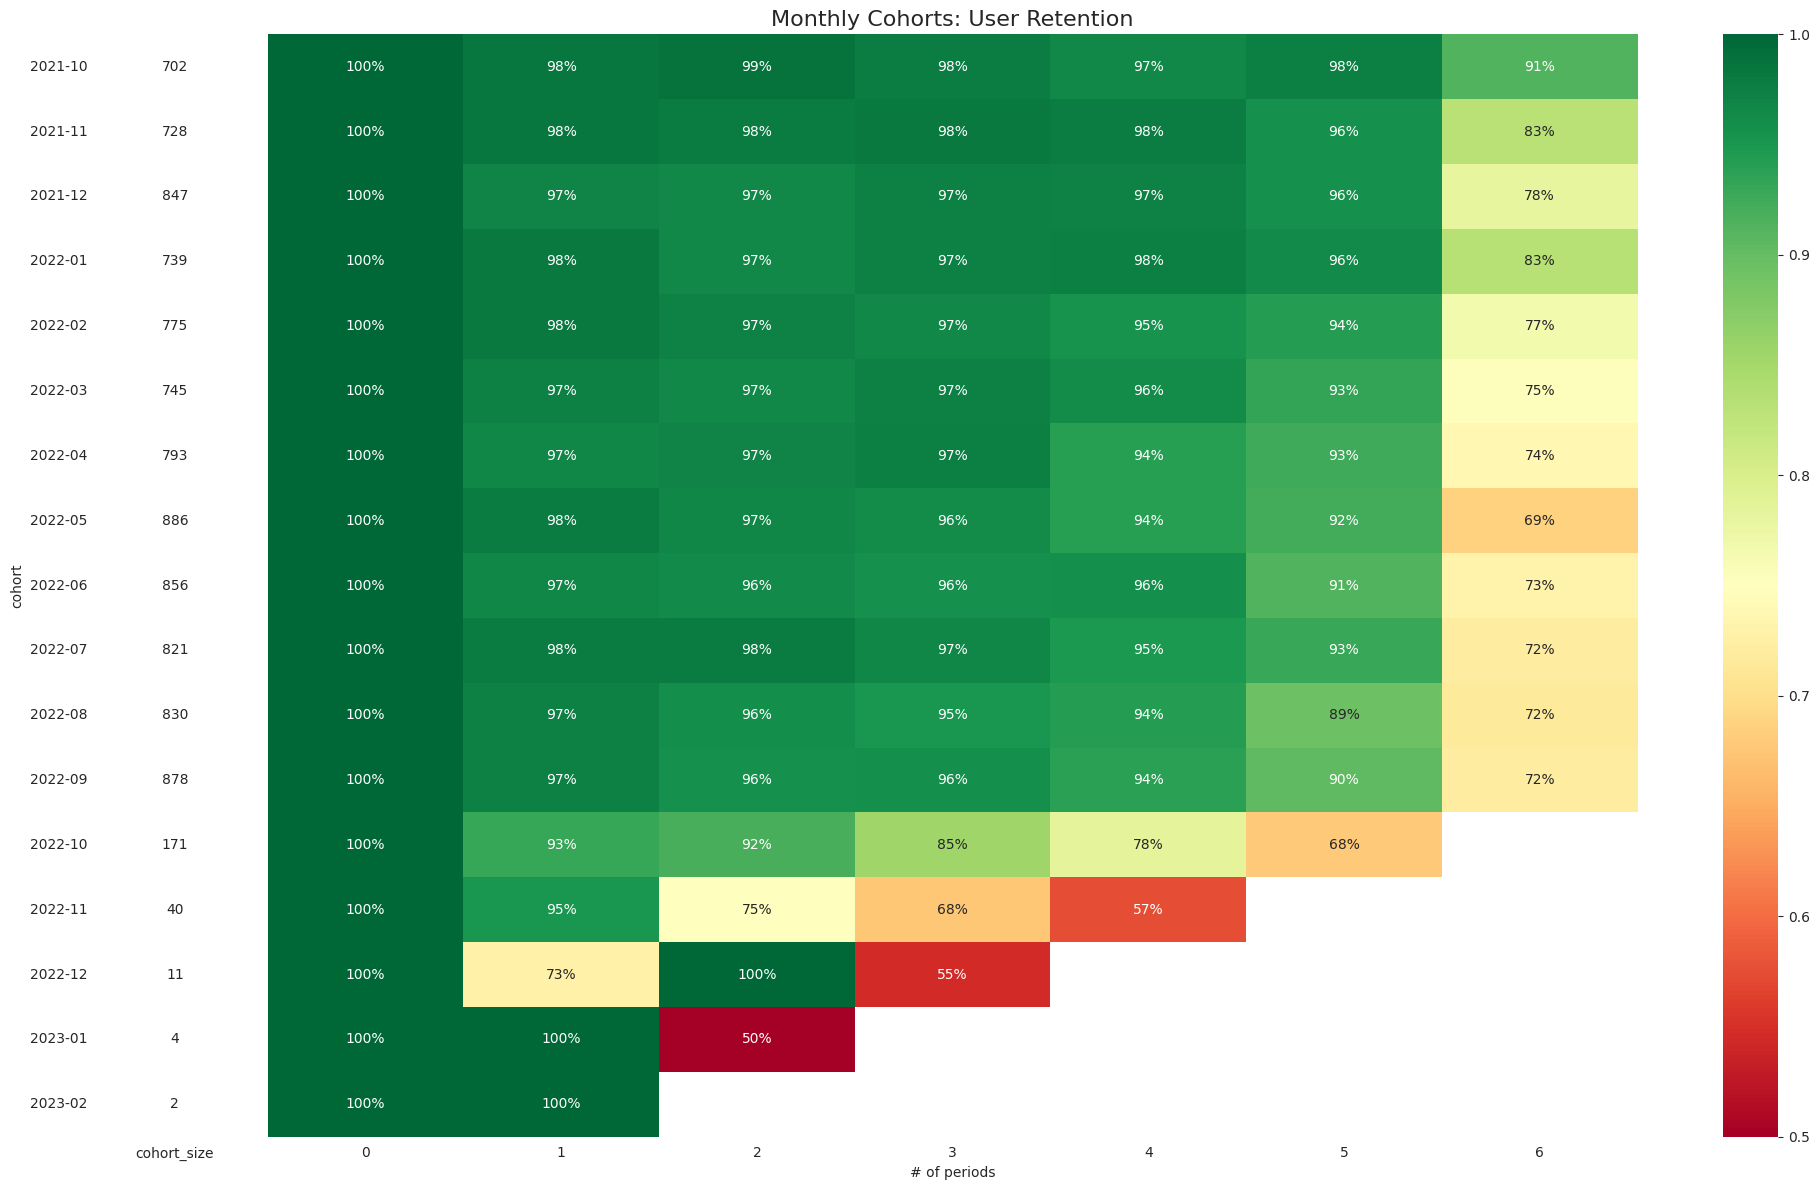

In [ ]:
import matplotlib.colors as mcolors
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(20, 12), sharey=True, gridspec_kw={'width_ratios': [1, 11]})

    # retention matrix
    sns.heatmap(retention_matrix,
                mask=retention_matrix.isnull(),
                annot=True,
                fmt='.0%',
                cmap='RdYlGn',
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Retention', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df,
                annot=True,
                cbar=False,
                fmt='g',
                cmap=white_cmap,
                ax=ax[0])

    fig.tight_layout()

можно ли сделать такой анализ по группам в процентиле? возможно мы начали терять наших лучших клиентов

# RFM Segmentation


In [ ]:
import datetime as dt

In [ ]:
PRESENT = dt.datetime(year=2021, month=10, day=7, hour=13, minute=14, second=31)
df['Date'] = pd.to_datetime(df['Date'],  format="%Y-%m-%d %H:%M:%S", errors='coerce')

In [ ]:
df

,user_id,mcc_code,currency_rk,transaction_amt,transaction_dttm,Date,order_month,cohort
0,3,3,1,-183.883957,2022-01-28 12:05:33,2022-01-28 12:05:33,2022-01,2022-01
1,3,3,1,-3206.437012,2022-01-28 12:52:30,2022-01-28 12:52:30,2022-01,2022-01
2,3,16,1,-153866.890625,2022-02-16 14:45:56,2022-02-16 14:45:56,2022-02,2022-01
3,3,56,1,-15144.601562,2022-03-09 19:58:29,2022-03-09 19:58:29,2022-03,2022-01
4,3,0,1,5297.908691,2022-03-12 18:11:31,2022-03-12 18:11:31,2022-03,2022-01
...,...,...,...,...,...,...,...,...
1405194,55930,1,1,-309.060669,2022-06-08 09:03:19,2022-06-08 09:03:19,2022-06,2022-03
1405195,55930,0,1,3399.340576,2022-06-14 14:48:55,2022-06-14 14:48:55,2022-06,2022-03
1405196,55930,13,1,-91.929306,2022-06-16 15:36:47,2022-06-16 15:36:47,2022-06,2022-03
1405197,55930,3,1,-4628.930664,2022-06-17 18:43:51,2022-06-17 18:43:51,2022-06,2022-03


# recency

In [ ]:
# Находим последнюю транзакцию для каждого пользователя
last_transaction = df.groupby('user_id')['Date'].max().reset_index()

# Вычисляем recency (количество дней с последней транзакции до PRESENT)
last_transaction['recency'] = (PRESENT - last_transaction['Date']).dt.days

# Объединяем с основным DataFrame, если нужно добавить столбец recency
df = pd.merge(df, last_transaction[['user_id', 'recency']], on='user_id', how='left')


In [ ]:
# Считаем количество транзакций для каждого пользователя
frequency = df.groupby('user_id')['transaction_amt'].count().reset_index()

# Переименовываем столбец для удобства
frequency.columns = ['user_id', 'frequency']

# Объединяем с основным DataFrame, если нужно добавить столбец frequency
df = pd.merge(df, frequency, on='user_id', how='left')


In [ ]:
# Преобразуем отрицательные значения по модулю только для столбцов recency и transaction_amt
df['recency'] = df['recency'].abs()
df['transaction_amt'] = df['transaction_amt'].abs()

# Проверим результат
print(df[['recency', 'transaction_amt']].head())


   recency  transaction_amt
0      220       183.883957
1      220      3206.437012
2      220    153866.890625
3      220     15144.601562
4      220      5297.908691


In [ ]:
print(df)

         user_id  mcc_code  currency_rk  transaction_amt     transaction_dttm  \
0              3         3            1       183.883957  2022-01-28 12:05:33   
1              3         3            1      3206.437012  2022-01-28 12:52:30   
2              3        16            1    153866.890625  2022-02-16 14:45:56   
3              3        56            1     15144.601562  2022-03-09 19:58:29   
4              3         0            1      5297.908691  2022-03-12 18:11:31   
...          ...       ...          ...              ...                  ...   
1405194    55930         1            1       309.060669  2022-06-08 09:03:19   
1405195    55930         0            1      3399.340576  2022-06-14 14:48:55   
1405196    55930        13            1        91.929306  2022-06-16 15:36:47   
1405197    55930         3            1      4628.930664  2022-06-17 18:43:51   
1405198    55930        12            1     19306.128906                    2   

                       Date

In [ ]:
# Группируем по user_id и суммируем значения transaction_amt для расчета Monetary
monetary = df.groupby('user_id')['transaction_amt'].sum().reset_index()

# Переименовываем столбец для ясности
monetary.columns = ['user_id', 'monetary']

# Объединяем с основным DataFrame rfm, если нужно
df = pd.merge(df, monetary, on='user_id', how='left')

In [ ]:
df.head()

,user_id,mcc_code,currency_rk,transaction_amt,transaction_dttm,Date,order_month,cohort,recency,frequency,monetary_x,monetary_y,monetary
0,3,3,1,183.883957,2022-01-28 12:05:33,2022-01-28 12:05:33,2022-01,2022-01,220,11,13706.416641,13706.416641,358510.042953
1,3,3,1,3206.437012,2022-01-28 12:52:30,2022-01-28 12:52:30,2022-01,2022-01,220,11,13706.416641,13706.416641,358510.042953
2,3,16,1,153866.890625,2022-02-16 14:45:56,2022-02-16 14:45:56,2022-02,2022-01,220,11,13706.416641,13706.416641,358510.042953
3,3,56,1,15144.601562,2022-03-09 19:58:29,2022-03-09 19:58:29,2022-03,2022-01,220,11,13706.416641,13706.416641,358510.042953
4,3,0,1,5297.908691,2022-03-12 18:11:31,2022-03-12 18:11:31,2022-03,2022-01,220,11,13706.416641,13706.416641,358510.042953


In [ ]:
rfm = df[['user_id', 'recency', 'monetary', 'frequency']]


In [ ]:
quartiles = rfm.quantile(q=[0.2,0.4,0.6,0.8,1])
print(quartiles, type(quartiles))

     user_id  recency      monetary  frequency
0.2  11534.0    255.0  1.809598e+05      116.0
0.4  22615.0    318.0  3.118102e+05      213.0
0.6  34151.0    403.0  5.201146e+05      319.0
0.8  44786.0    468.0  9.807642e+05      484.0
1.0  55930.0    530.0  1.824548e+07     1483.0 <class 'pandas.core.frame.DataFrame'>


In [ ]:
quartiles=quartiles.to_dict()
quartiles

{'user_id': {0.2: 11534.0,
  0.4: 22615.0,
  0.6: 34151.0,
  0.8: 44786.0,
  1.0: 55930.0},
 'recency': {0.2: 255.0, 0.4: 318.0, 0.6: 403.0, 0.8: 468.0, 1.0: 530.0},
 'monetary': {0.2: 180959.7553405762,
  0.4: 311810.19056129456,
  0.6: 520114.6163787842,
  0.8: 980764.1578063965,
  1.0: 18245481.416324615},
 'frequency': {0.2: 116.0, 0.4: 213.0, 0.6: 319.0, 0.8: 484.0, 1.0: 1483.0}}

In [ ]:
## for Recency

def RClass(x,p,d):
    if x <= d[p][0.2]:
        return 5
    elif x <= d[p][0.40]:
        return 4
    elif x <= d[p][0.60]:
        return 3
    elif x <= d[p][0.80]:
        return 2
    else:
        return 1

## for Frequency and Monetary value

def FMClass(x,p,d):
    if x <= d[p][0.20]:
        return 1
    if x <= d[p][0.40]:
        return 2
    elif x <= d[p][0.60]:
        return 3
    elif x <= d[p][0.80]:
       return 4
    else:
        return 5

In [ ]:
rfmSeg = rfm
rfmSeg['R_Quartile'] = rfmSeg['recency'].apply(RClass, args=('recency',quartiles,))
rfmSeg['F_Quartile'] = rfmSeg['frequency'].apply(FMClass, args=('frequency',quartiles,))
rfmSeg['M_Quartile'] = rfmSeg['monetary'].apply(FMClass, args=('monetary',quartiles,))

<ipython-input-54-619a113db9d2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfmSeg['R_Quartile'] = rfmSeg['recency'].apply(RClass, args=('recency',quartiles,))
<ipython-input-54-619a113db9d2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfmSeg['F_Quartile'] = rfmSeg['frequency'].apply(FMClass, args=('frequency',quartiles,))
<ipython-input-54-619a113db9d2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

In [ ]:
rfmSeg['RFMClass'] = rfmSeg.R_Quartile.map(str) \
                            + rfmSeg.F_Quartile.map(str) \
                            + rfmSeg.M_Quartile.map(str)

<ipython-input-55-4bde2bf363e4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfmSeg['RFMClass'] = rfmSeg.R_Quartile.map(str) \


In [ ]:
rfmSeg.head()

,user_id,recency,monetary,frequency,R_Quartile,F_Quartile,M_Quartile,RFMClass
0,3,220,358510.042953,11,5,1,3,513
1,3,220,358510.042953,11,5,1,3,513
2,3,220,358510.042953,11,5,1,3,513
3,3,220,358510.042953,11,5,1,3,513
4,3,220,358510.042953,11,5,1,3,513


In [ ]:
rfmSeg.groupby('RFMClass').agg('monetary').mean()

,monetary
RFMClass,
111,8.567629e+04
112,2.355336e+05
113,3.928667e+05
114,6.915396e+05
115,1.680205e+06
...,...
551,1.073559e+05
552,2.465788e+05
553,4.308703e+05


In [ ]:
rfmSeg.groupby('M_Quartile').agg('monetary').mean()

,monetary
M_Quartile,
1,1.099838e+05
2,2.442799e+05
3,4.021120e+05
4,7.069838e+05
5,2.366797e+06


In [ ]:
rfmSeg['Total Score'] = rfmSeg['R_Quartile'] + rfmSeg['F_Quartile'] +rfmSeg['M_Quartile']
print(rfmSeg.head(), rfmSeg.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1405199 entries, 0 to 1405198
Data columns (total 9 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   user_id      1405199 non-null  int64  
 1   recency      1405199 non-null  int64  
 2   monetary     1405199 non-null  float64
 3   frequency    1405199 non-null  int64  
 4   R_Quartile   1405199 non-null  int64  
 5   F_Quartile   1405199 non-null  int64  
 6   M_Quartile   1405199 non-null  int64  
 7   RFMClass     1405199 non-null  object 
 8   Total Score  1405199 non-null  int64  
dtypes: float64(1), int64(7), object(1)
memory usage: 96.5+ MB
   user_id  recency       monetary  frequency  R_Quartile  F_Quartile  \
0        3      220  358510.042953         11           5           1   
1        3      220  358510.042953         11           5           1   
2        3      220  358510.042953         11           5           1   
3        3      220  358510.042953         11    

<ipython-input-59-aec318964dd8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfmSeg['Total Score'] = rfmSeg['R_Quartile'] + rfmSeg['F_Quartile'] +rfmSeg['M_Quartile']


In [ ]:
rfmSeg.groupby('Total Score').agg('monetary').mean()

,monetary
Total Score,
3,8.567629e+04
4,1.251705e+05
5,1.714441e+05
6,2.319398e+05
7,2.903656e+05
8,4.111638e+05
9,5.091010e+05
10,6.717383e+05
11,1.151935e+06


In [ ]:
rfmSeg.groupby('Total Score').agg('frequency').mean()

,frequency
Total Score,
3,65.236198
4,94.137230
5,119.986953
6,146.827224
7,187.636713
8,226.598586
9,291.498528
10,343.164864
11,422.689153


In [ ]:
rfmSeg.groupby('Total Score').agg('recency').mean()

,recency
Total Score,
3,507.583636
4,468.744440
5,438.067815
6,410.704814
7,383.178759
8,366.142096
9,356.638708
10,346.161731
11,336.727881


<Axes: xlabel='Total Score'>

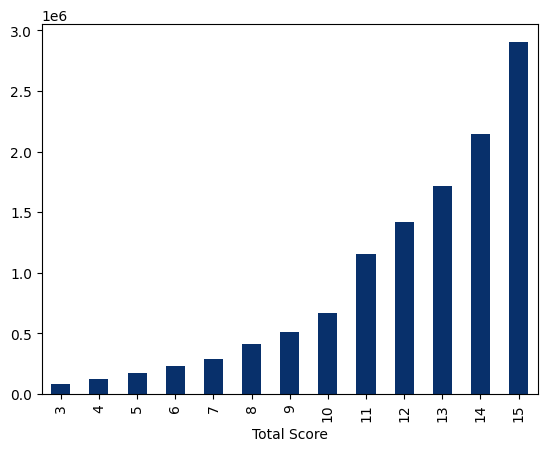

In [ ]:
rfmSeg.groupby('Total Score').agg('monetary').mean().plot(kind='bar', colormap='Blues_r')

In [ ]:
seg_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At Risk',
    r'[1-2]5': 'Can\'t Lose',
    r'3[1-2]': 'About to Sleep',
    r'33': 'Need Attention',
    r'[3-4][4-5]': 'Loyal Customers',
    r'41': 'Promising',
    r'51': 'New Customers',
    r'[4-5][2-3]': 'Potential Loyalists',
    r'5[4-5]': 'Champions'
    }

In [ ]:
rfm['segment'] = rfm['R_Quartile'].astype(str) + rfm['F_Quartile'].astype(str)
rfm['segment'] = rfm['segment'].replace(seg_map, regex=True)

<ipython-input-66-1495555bda3e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm['segment'] = rfm['R_Quartile'].astype(str) + rfm['F_Quartile'].astype(str)
<ipython-input-66-1495555bda3e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm['segment'] = rfm['segment'].replace(seg_map, regex=True)


In [ ]:
rfm.head()

,user_id,recency,monetary,frequency,R_Quartile,F_Quartile,M_Quartile,RFMClass,Total Score,segment
0,3,220,358510.042953,11,5,1,3,513,9,New Customers
1,3,220,358510.042953,11,5,1,3,513,9,New Customers
2,3,220,358510.042953,11,5,1,3,513,9,New Customers
3,3,220,358510.042953,11,5,1,3,513,9,New Customers
4,3,220,358510.042953,11,5,1,3,513,9,New Customers


In [ ]:
segments_counts = rfm['segment'].value_counts().sort_values(ascending=True)
segments_counts

,count
segment,
Need Attention,51106
Promising,51795
New Customers,62661
About to Sleep,103169
Champions,106658
Can't Lose,111424
Loyal Customers,221602
At Risk,224281
Hibernating,225515


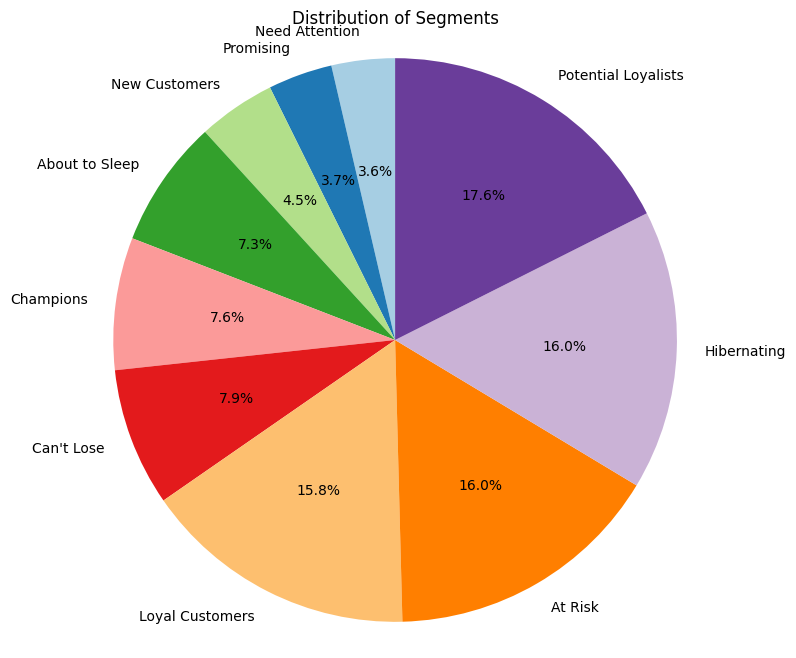

In [ ]:
import matplotlib.pyplot as plt

# Данные для круговой диаграммы (предположим, что segments_counts уже подсчитан)
segments_counts = rfm['segment'].value_counts().sort_values(ascending=True)

# Создаем круговую диаграмму
plt.figure(figsize=(8, 8))
plt.pie(segments_counts, labels=segments_counts.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)

# Добавляем заголовок
plt.title('Distribution of Segments')

# Делаем оси равными, чтобы круг не был искажен
plt.axis('equal')

# Показываем диаграмму
plt.show()


In [ ]:
rfm[["segment","recency","frequency","monetary"]].groupby("segment").agg(["mean","count"])

recency           frequency              monetary  \
                           mean   count        mean   count          mean   
segment                                                                     
About to Sleep       364.624703  103169  109.234276  103169  4.004962e+05   
At Risk              468.149112  224281  331.555553  224281  6.235131e+05   
Can't Lose           467.424917  111424  715.177089  111424  1.576414e+06   
Champions            212.427413  106658  553.859907  106658  1.409370e+06   
Hibernating          469.643922  225515  117.022908  225515  3.667950e+05   
Loyal Customers      322.110613  221602  580.352316  221602  1.258061e+06   
Need Attention       364.856005   51106  268.413454   51106  5.568655e+05   
New Customers        216.473692   62661   66.801408   62661  3.808918e+05   
Potential Loyalists  253.543221  246988  214.966338  246988  5.513936e+05   
Promising            290.725881   51795   68.518564   51795  3.635397e+05   

                             
                      count  
segment                      
About to Sleep       103169  
At Risk              224281  
Can't Lose           111424  
Champions            106658  
Hibernating          225515  
Loyal Customers      221602  
Need Attention        51106  
New Customers         62661  
Potential Loyalists  246988  
Promising             51795

<ipython-input-70-8fe0a07cf688>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rfm[col])


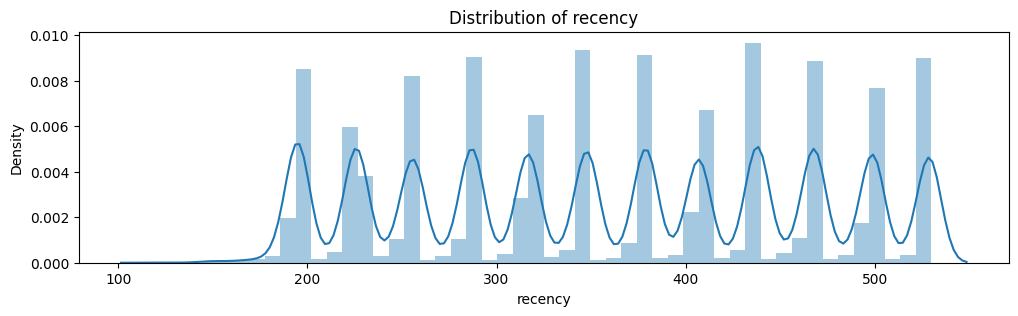

<ipython-input-70-8fe0a07cf688>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rfm[col])


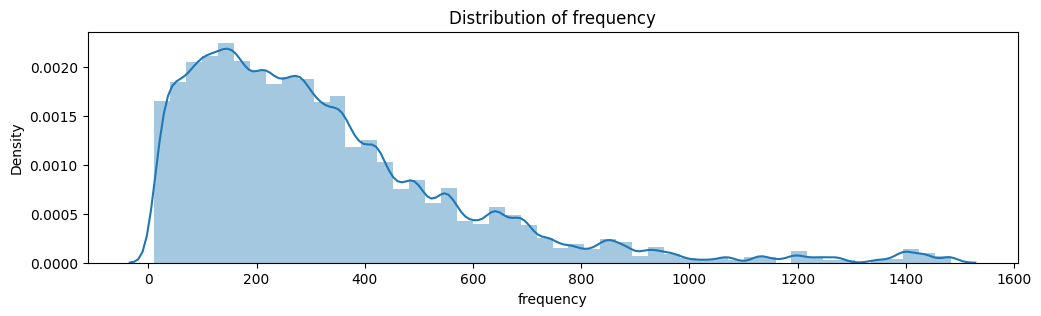

<ipython-input-70-8fe0a07cf688>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rfm[col])


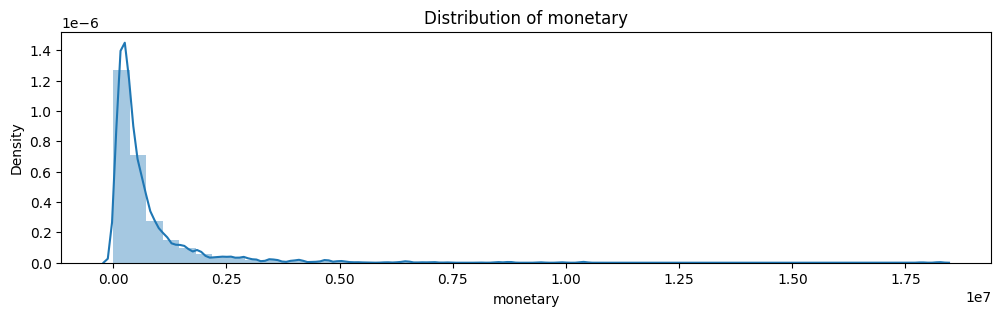

In [ ]:
colnames = ['recency', 'frequency', 'monetary']

for col in colnames:
    fig, ax = plt.subplots(figsize=(12,3))
    sns.distplot(rfm[col])
    ax.set_title('Distribution of %s' % col)
    plt.show()

<ipython-input-92-8f8a51cde9b2>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rfm[rfm['segment']==segment][col], label=segment)
<ipython-input-92-8f8a51cde9b2>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rfm[rfm['segment']==segment][col], label=segment)
<ipython-input-92-8f8a51cde9b2>:6:

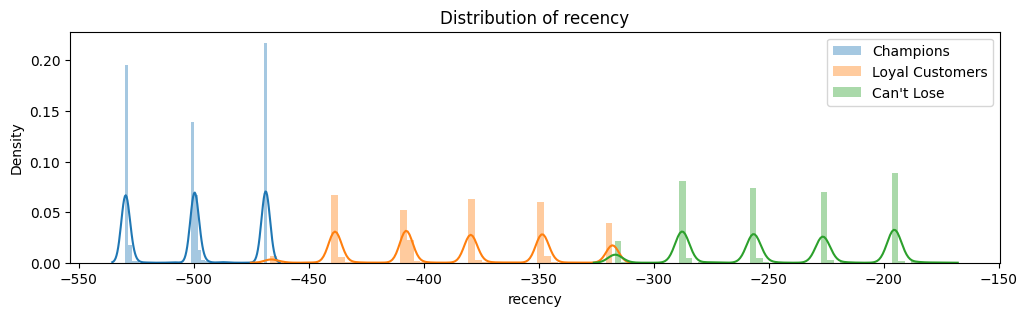

<ipython-input-92-8f8a51cde9b2>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rfm[rfm['segment']==segment][col], label=segment)
<ipython-input-92-8f8a51cde9b2>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rfm[rfm['segment']==segment][col], label=segment)
<ipython-input-92-8f8a51cde9b2>:6:

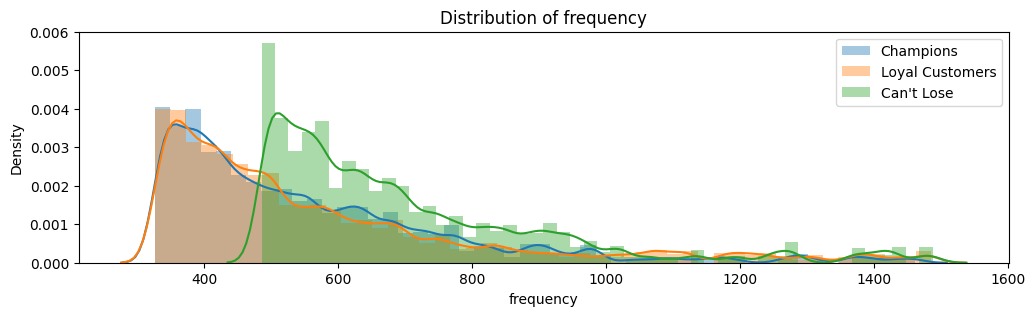

<ipython-input-92-8f8a51cde9b2>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rfm[rfm['segment']==segment][col], label=segment)
<ipython-input-92-8f8a51cde9b2>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rfm[rfm['segment']==segment][col], label=segment)
<ipython-input-92-8f8a51cde9b2>:6:

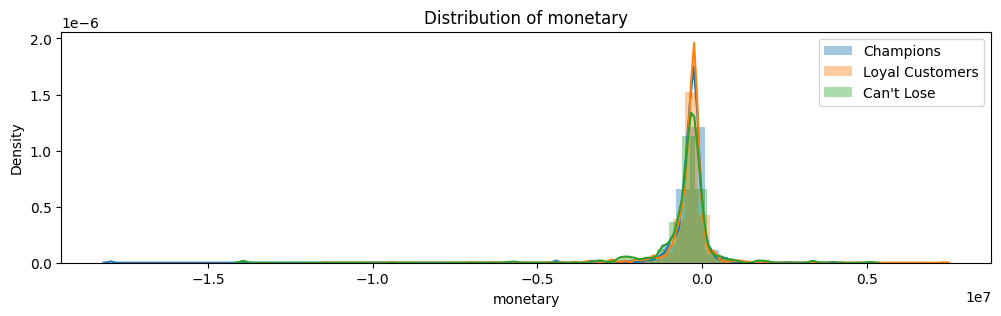

In [ ]:
segments = ['Champions', 'Loyal Customers', "Can't Lose"]

for col in colnames:
    fig, ax = plt.subplots(figsize=(12,3))
    for segment in segments:
        sns.distplot(rfm[rfm['segment']==segment][col], label=segment)
    ax.set_title('Distribution of %s' % col)
    plt.legend()
    plt.show()

In [ ]:
agg_dict2 = {
    'recency': 'count',
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': 'sum'
}

df_analysis = rfm.groupby('segment').agg(agg_dict2).sort_values(by='recency').reset_index()
df_analysis.rename({'segment': 'label', 'recency': 'count'}, axis=1, inplace=True)
df_analysis['count_share'] = df_analysis['count'] / df_analysis['count'].sum()
df_analysis['monetary_share'] = df_analysis['monetary'] / df_analysis['monetary'].sum()
df_analysis['monetary'] = df_analysis['monetary'] / df_analysis['count']

In [ ]:
pip install squarify

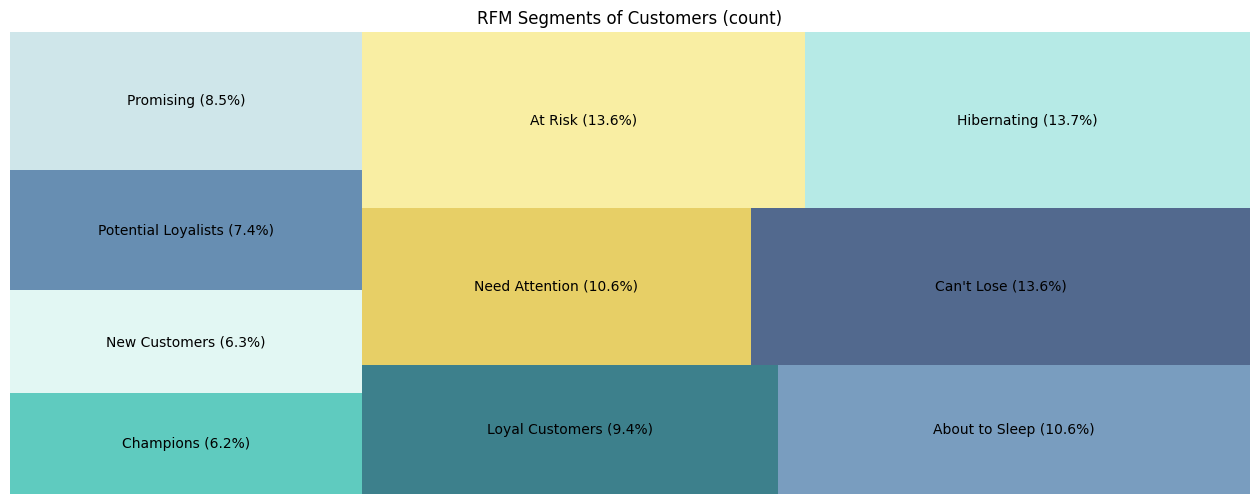

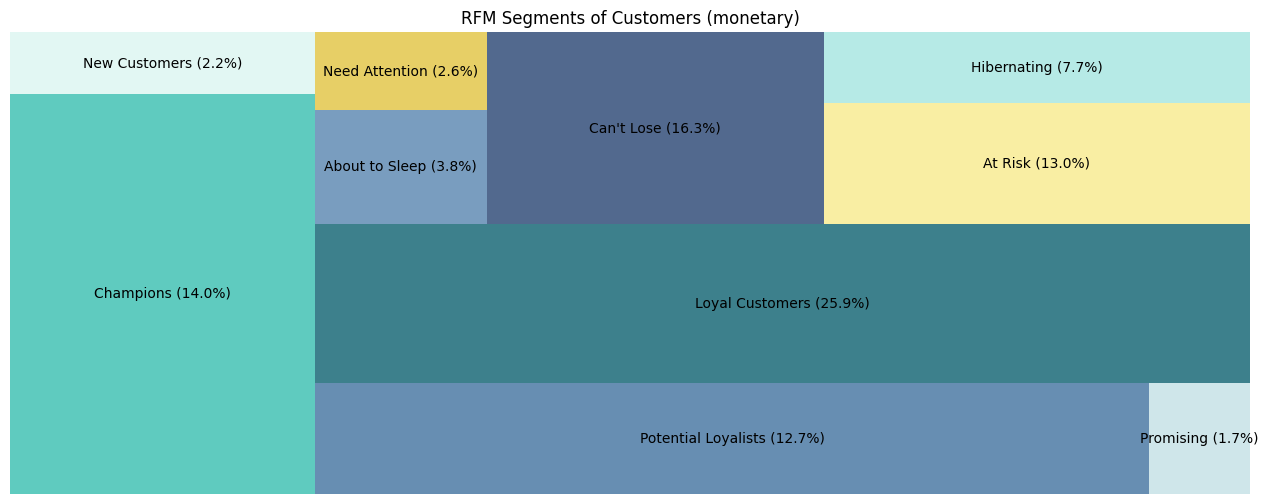

In [ ]:
import squarify
colors = ['#37BEB0', '#DBF5F0', '#41729F', '#C3E0E5', '#0C6170', '#5885AF', '#E1C340', '#274472', '#F8EA8C', '#A4E5E0', '#1848A0']

for col in ['count', 'monetary']:
    labels = df_analysis['label'] + df_analysis[col + '_share'].apply(lambda x: ' ({0:.1f}%)'.format(x*100))

    fig, ax = plt.subplots(figsize=(16,6))
    squarify.plot(sizes=df_analysis[col], label=labels, alpha=.8, color=colors)
    ax.set_title('RFM Segments of Customers (%s)' % col)
    plt.axis('off')
    plt.show()

# Cluster analysis

In [ ]:
rfm.head(10)

,user_id,recency,monetary,frequency,R_Quartile,F_Quartile,M_Quartile,RFMClass,Total Score,segment
0,3,220,358510.042953,11,5,1,3,513,9,New Customers
1,3,220,358510.042953,11,5,1,3,513,9,New Customers
2,3,220,358510.042953,11,5,1,3,513,9,New Customers
3,3,220,358510.042953,11,5,1,3,513,9,New Customers
4,3,220,358510.042953,11,5,1,3,513,9,New Customers
5,3,220,358510.042953,11,5,1,3,513,9,New Customers
6,3,220,358510.042953,11,5,1,3,513,9,New Customers
7,3,220,358510.042953,11,5,1,3,513,9,New Customers
8,3,220,358510.042953,11,5,1,3,513,9,New Customers
9,3,220,358510.042953,11,5,1,3,513,9,New Customers


In [ ]:
df_cus = rfm.reset_index()[["recency","frequency","monetary", 'Total Score',"segment"]]

In [ ]:
from sklearn.preprocessing import StandardScaler
df_segment = df_cus[['recency', 'frequency', 'monetary', 'Total Score']]
scaler = StandardScaler()
scaler.fit(df_segment)
scaled_df = pd.DataFrame(scaler.transform(df_segment),columns= df_segment.columns)

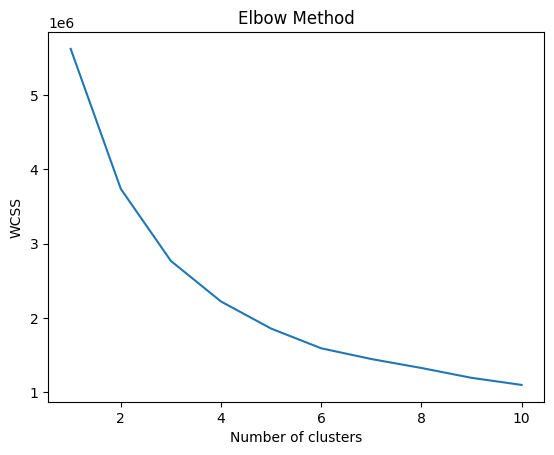

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# Determine the optimal number of clusters using the Elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(scaled_df)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')  # Within-Cluster-Sum-of-Squares
plt.show()

In [ ]:
#Apply K-Means clustering
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10, random_state=0)
df_cus['cluster'] = kmeans.fit_predict(scaled_df)

<ipython-input-96-3ccd11f406f1>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  pl = sns.countplot(x=df_cus['cluster'], palette=pal)
<ipython-input-96-3ccd11f406f1>:3: UserWarning: 
The palette list has fewer values (4) than needed (5) and will cycle, which may produce an uninterpretable plot.
  pl = sns.countplot(x=df_cus['cluster'], palette=pal)


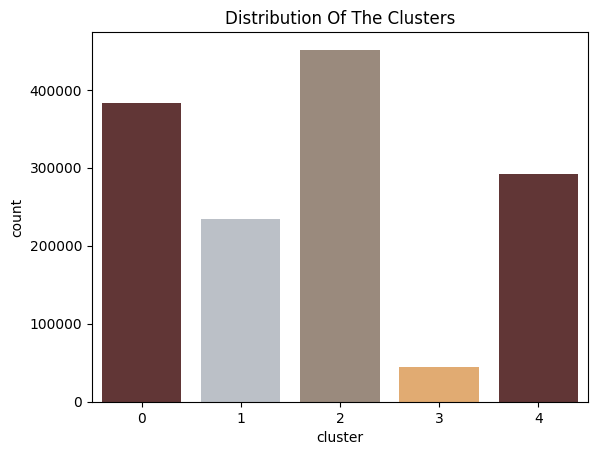

In [ ]:
#Plotting countplot of clusters
pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
pl = sns.countplot(x=df_cus['cluster'], palette=pal)
pl.set_title("Distribution Of The Clusters")
plt.show()

In [ ]:
df_cus.groupby('cluster').agg({
    'recency' : ['mean','min','max'],
    'frequency' : ['mean','min','max'],
    'monetary' : ['mean','min','max','count']
})

recency             frequency                 monetary  \
               mean  min  max        mean  min   max          mean   
cluster                                                              
0        454.409294  319  530  154.846423   11   424  2.840095e+05   
1        265.351362  184  380  543.209168  109  1378  1.198029e+06   
2        273.103738  120  403  188.869813   11   499  4.032160e+05   
3        341.806910  189  530  919.707275   49  1483  5.729288e+06   
4        444.833334  336  530  483.815522   98  1434  8.570980e+05   

                                             
                  min           max   count  
cluster                                      
0        4.992680e+01  4.269519e+06  383170  
1        1.073559e+05  4.211401e+06  234701  
2        8.687745e+01  4.722622e+06  451396  
3        2.865519e+06  1.824548e+07   44342  
4        7.159122e+04  4.163175e+06  291590

In [ ]:
df_cus.groupby(['cluster','segment']).size()

cluster  segment            
0        About to Sleep          64702
         At Risk                 93990
         Hibernating            219544
         Need Attention           4934
1        Champions               86097
         Loyal Customers        122162
         Need Attention            592
         New Customers             109
         Potential Loyalists     25741
2        About to Sleep          36755
         Champions               11280
         Loyal Customers         32914
         Need Attention          36228
         New Customers           62439
         Potential Loyalists    220052
         Promising               51728
3        About to Sleep            778
         At Risk                  2306
         Can't Lose              10759
         Champions                9281
         Hibernating               131
         Loyal Customers         19712
         New Customers             113
         Potential Loyalists      1195
         Promising                  67
4        About to Sleep            934
         At Risk                127985
         Can't Lose             100665
         Hibernating              5840
         Loyal Customers         46814
         Need Attention           9352
dtype: int64

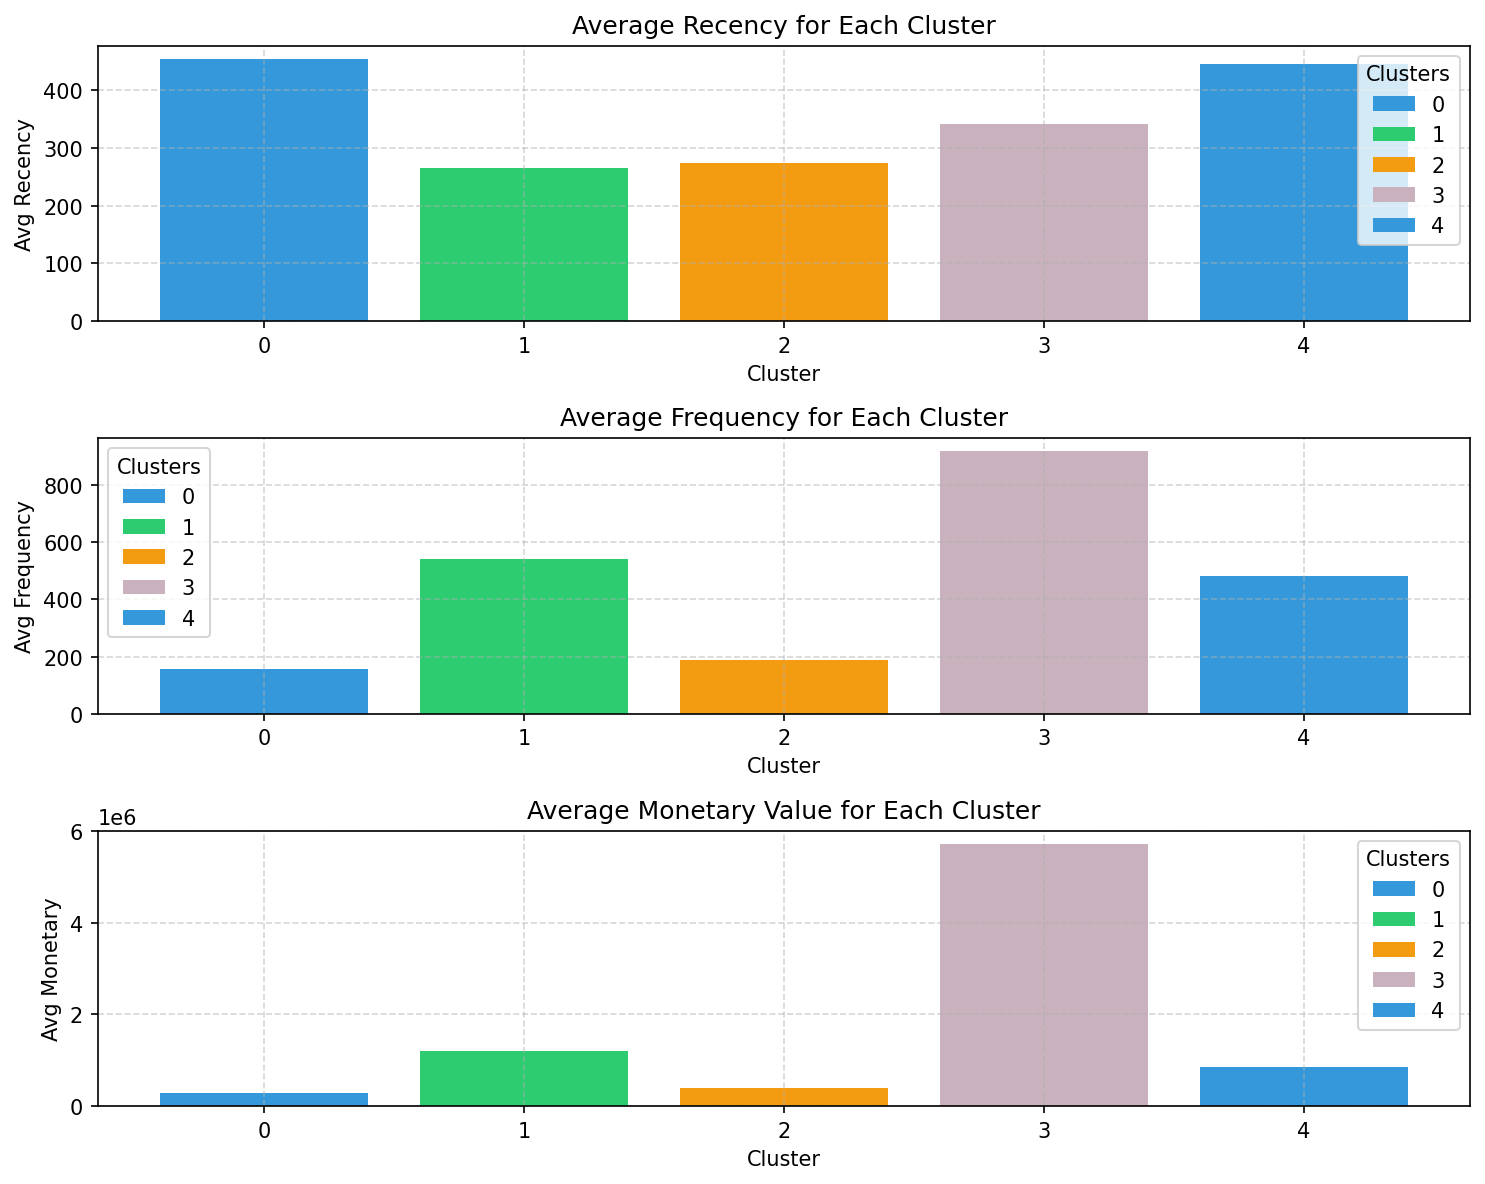

In [ ]:
cluster_summary = df_cus.groupby('cluster').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': 'mean'
}).reset_index()


colors = ['#3498db', '#2ecc71', '#f39c12','#C9B1BD']

# Plot the average RFM scores for each cluster
plt.figure(figsize=(10, 8),dpi=150)

# Plot Avg Recency
plt.subplot(3, 1, 1)
bars = plt.bar(cluster_summary.index, cluster_summary['recency'], color=colors)
plt.xlabel('Cluster')
plt.ylabel('Avg Recency')
plt.title('Average Recency for Each Cluster')

plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(bars, cluster_summary.index, title='Clusters')

# Plot Avg Frequency
plt.subplot(3, 1, 2)
bars = plt.bar(cluster_summary.index, cluster_summary['frequency'], color=colors)
plt.xlabel('Cluster')
plt.ylabel('Avg Frequency')
plt.title('Average Frequency for Each Cluster')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(bars, cluster_summary.index, title='Clusters')

# Plot Avg Monetary
plt.subplot(3, 1, 3)
bars = plt.bar(cluster_summary.index, cluster_summary['monetary'], color=colors)
plt.xlabel('Cluster')
plt.ylabel('Avg Monetary')
plt.title('Average Monetary Value for Each Cluster')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(bars, cluster_summary.index, title='Clusters')

plt.tight_layout()
plt.show()